# Imports

In [1]:
from numpy import bincount
from torch.optim import AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm as progress
from torch.nn.utils import clip_grad_norm_ 
from pandas import read_csv, DataFrame, concat
from torch.nn.functional import relu, max_pool1d
from torch import IntTensor, FloatTensor, no_grad
from torch import device, cuda, save, load, sigmoid  
from sklearn.model_selection import train_test_split
from torch.nn import ModuleList, Embedding, Conv1d, Dropout, Linear, BCELoss
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Constant Variables
batch_size = 1024
device = device("cuda" if cuda.is_available() else "cpu")

# Loading SMS Data

In [2]:
df = read_csv("../../data/sms.csv")
df = df.drop(columns=["Unnamed: 0"])
df.sample(5)

,text,type
4904,"[5897, 1656, 3, 3, 3, 3, 3, 76, 5898, 5899, 59...",1
3785,"[52, 140, 57, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0
2135,"[874, 461, 11, 12, 15, 817, 900, 0, 0, 0, 0, 0...",0
405,"[665, 266, 198, 608, 86, 362, 15, 268, 624, 14...",0
4357,"[195, 568, 117, 375, 3, 651, 57, 567, 519, 4, ...",1


# Preparing SMS Data


In [3]:
# Load & Prepare Data
df["text"] = df["text"].apply(lambda sms: [int(word) for word in sms[1:-1].split(", ")])
df["type"] = df["type"].apply(lambda label: int(label))

# # Train / Valid / Test Split
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["type"], test_size=0.30, stratify=df["type"], random_state=2022)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify=y_test, random_state=2022)

# Training weight
train_weight = (1./bincount(y_train))[y_train]

# Train / Valid / Test TensorDataset
train_dataset = TensorDataset(IntTensor(x_train.to_list()), FloatTensor(y_train.to_list()))
valid_dataset =  TensorDataset(IntTensor(x_valid.to_list()), FloatTensor(y_valid.to_list()))
test_dataset = TensorDataset(IntTensor(x_test.to_list()), FloatTensor(y_test.to_list()))

# Train / Test / Valid Loaders
train_loader = DataLoader(train_dataset, sampler=WeightedRandomSampler(train_weight, len(train_weight)-1), batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size)
test_loader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Model

In [4]:
class SMSClassifier(ModuleList):
    def __init__(self, path):
        super(SMSClassifier, self).__init__()
        self.path = path
        self.embedding = Embedding(num_embeddings=6260, embedding_dim=8, padding_idx=0)
        self.dropout1 = Dropout(0.5)
        self.conv1 = Conv1d(300, 200, kernel_size=2, stride=1, padding=1)
        self.dropout2 = Dropout(0.5)
        self.conv2 = Conv1d(200, 100, kernel_size=3, stride=2, padding=1)
        self.dropout3 = Dropout(0.5)
        self.conv3 = Conv1d(100, 64, kernel_size=3, stride=2, padding=1)
        self.dropout4 = Dropout(0.5)
        self.fc1 = Linear(64, 32)
        self.fc2 = Linear(32, 16)
        self.fc3 = Linear(16, 1)

    def forward(self, sentence):
        sentence = self.embedding(sentence)
        sentence = self.dropout1(sentence)
        sentence = self.conv1(sentence)
        sentence = relu(sentence, inplace=False)
        sentence = max_pool1d(sentence, kernel_size=2, stride=1, padding=1)
        sentence = self.dropout2(sentence)
        sentence = self.conv2(sentence)
        sentence = relu(sentence, inplace=False)
        sentence = max_pool1d(sentence, kernel_size=3, stride=2, padding=1)
        sentence = self.dropout3(sentence)
        sentence = self.conv3(sentence)
        sentence = relu(sentence, inplace=False)
        sentence = max_pool1d(sentence, kernel_size=3, stride=2, padding=1)
        sentence = sentence.view(-1, 64)
        sentence = self.dropout4(sentence)
        sentence = self.fc1(sentence)
        sentence = relu(sentence, inplace=True)
        sentence = self.fc2(sentence)
        sentence = relu(sentence, inplace=True)
        sentence = self.fc3(sentence).squeeze()
        return sigmoid(sentence)

    def fit(self, loader, epochs, optim, loss_fn):
        train_loss, valid_loss = [1], [1]
        for epoch in (tracker := progress(range(epochs))):
            tracker.set_description(f"Epoch #{epoch+1}")
            # Train Step
            train_loss.append(self.train_step(loader[0], optim, loss_fn))
            # Eval Step
            valid_loss.append(loss := self.eval_step(loader[1], loss_fn))
            # Updating tracker
            if epoch == epochs-1:
                for step, loss in enumerate(valid_loss):
                    if loss == min(valid_loss):
                        tracker.set_description(f"Best Epoch #{step}")
                        tracker.set_postfix_str(f"Training Loss = {train_loss[step]}, Validiation Loss = {valid_loss[step]}")
            else:
                tracker.set_postfix_str(f"Training Loss = {train_loss[-1]}, Validiation Loss = {valid_loss[-1]}")
            # Saving Model If Performance Improves
            if loss <= min(valid_loss):
                self.save()
            
        # Plotting Results
        fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
        ax.set_title("Training Loss (Blue) vs Validation Loss (Red)")
        ax.plot(train_loss, "b")
        ax.plot(valid_loss, "r")
        ax.set_xlim((0, len(train_loss)-1))
        ax.set_ylim((0, 1))

    def train_step(self, loader, optim, loss_fn):
        losses = []
        self.train()
        for step, batch in enumerate(loader):
            self.zero_grad()
            # Training Step
            prediction = self.forward(batch[0].to(device))
            loss = loss_fn(prediction, batch[1].type(FloatTensor).to(device))
            # Recording Training Result
            losses.append(loss.item())
            # Refresh Step
            loss.backward()
            clip_grad_norm_(self.parameters(), max_norm=1.0, norm_type=1)
            optim.step()
        return sum(losses)/len(losses)

    def eval_step(self, loader, loss_fn):
        losses = []
        self.eval()
        with no_grad():
            for step, batch in enumerate(loader):
                # Evaluation Step
                prediction = self.forward(batch[0].to(device))
                loss = loss_fn(prediction, batch[1].type(FloatTensor).to(device))
                # Recording Evaluation Result
                losses.append(loss.item())       
        return sum(losses)/len(losses)

    def evaluate(self, loader):
        self.load()
        y_true, y_pred = [], []
        self.eval()
        with no_grad():
            for step, batch in enumerate(loader):
                y_pred.extend([int(pred > 0.5) for pred in self.forward(batch[0].to(device)).cpu().numpy()])
                y_true.extend(batch[1])
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        rc1, rc2, rc3 = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(rc2,  rc1)
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nPR_AUC: {pr_auc}")
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=[0, 1]).plot()
        plt.show()
        return accuracy, precision, recall, pr_auc
    
    def saveResults(self, lib, nam, typ, acc, pre, rec, pr):
        df = read_csv("../../data/results.csv")
        df2 = DataFrame([[lib, nam, typ, acc, pre, rec, pr]], 
                        columns=["Library", "Model", "Type", "Accuracy", "Precision", "Recall", "PR_AUC"])
        df = concat([df2, df])
        if "Unnamed: 0" in df:
            df = df.drop(columns=["Unnamed: 0"])
        df.to_csv("../../data/results.csv")

    def save(self):
        save(self.state_dict(), self.path)

    def load(self):
        self.load_state_dict(load(self.path))

# Model Summary

In [5]:
model = SMSClassifier(path="../../models/cnn.pt").to(device)
print(model)

SMSClassifier(
  (embedding): Embedding(6260, 8, padding_idx=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(300, 200, kernel_size=(2,), stride=(1,), padding=(1,))
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): Conv1d(200, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv3): Conv1d(100, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


# Model Training

Best Epoch #272: 100% 300/300 [00:29<00:00, 10.30it/s, Training Loss = 0.03311215853318572, Validiation Loss = 0.08456319570541382]


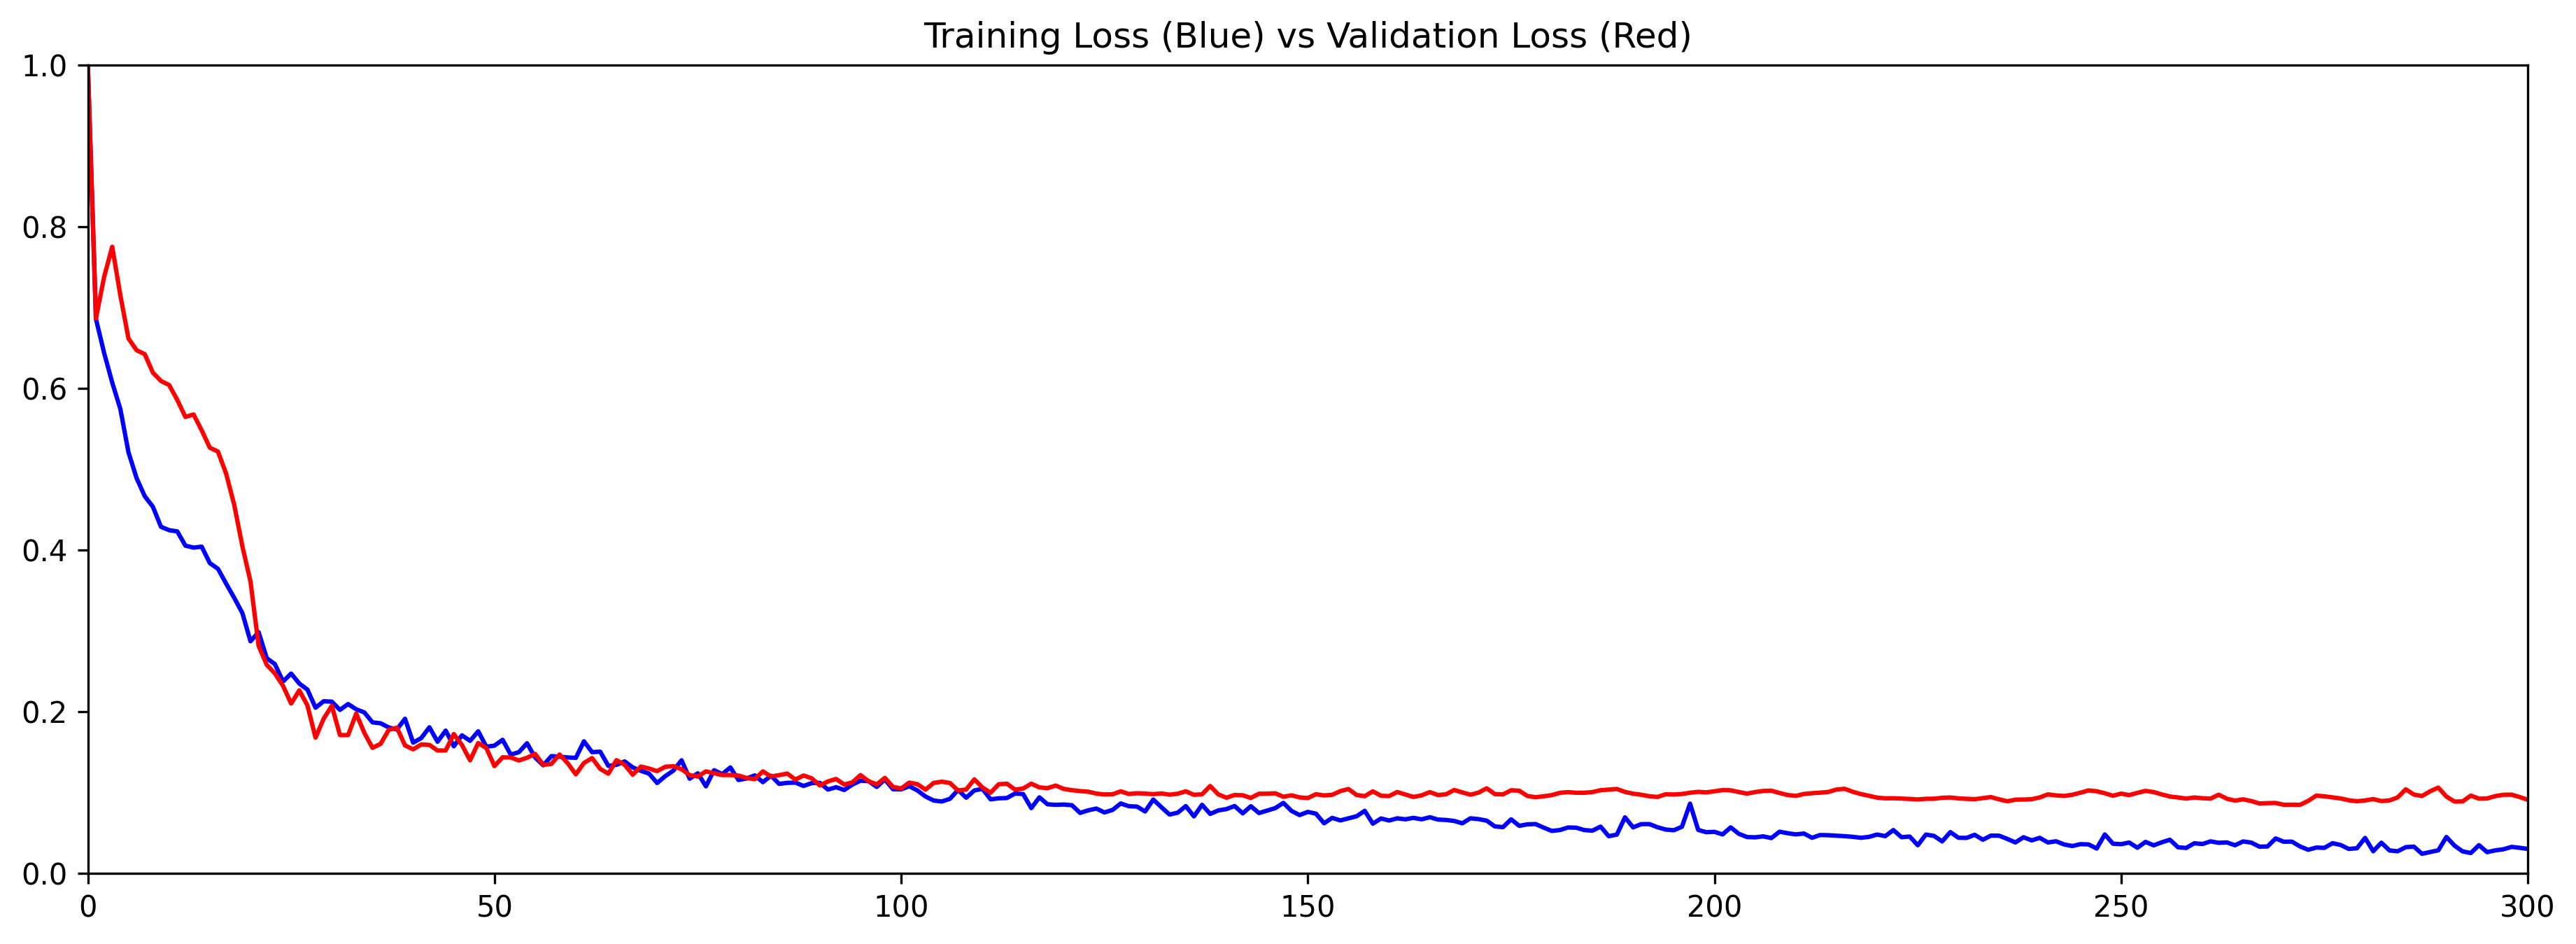

In [6]:
model.fit([train_loader, valid_loader], 300, AdamW(model.parameters(), lr=1e-3), BCELoss())

# Model Evaluation

Accuracy: 0.9992305719415234
Precision: 0.9984391259105099
Recall: 1.0
PR_AUC: 0.9992195629552549


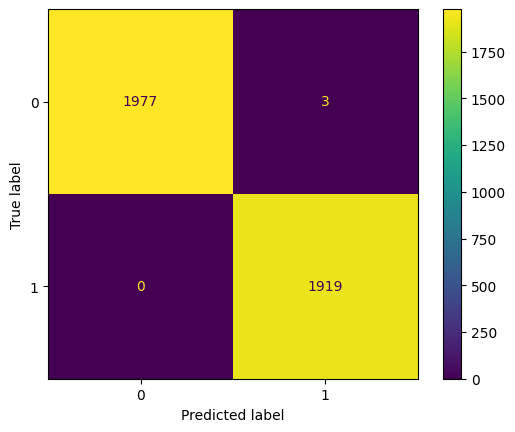

In [7]:
acc, pre, re, pr = model.evaluate(train_loader)
model.saveResults("pytorch", "cnn", "train", acc, pre, re, pr)

Accuracy: 0.9772727272727273
Precision: 0.9345794392523364
Recall: 0.8928571428571429
PR_AUC: 0.9208953245475626


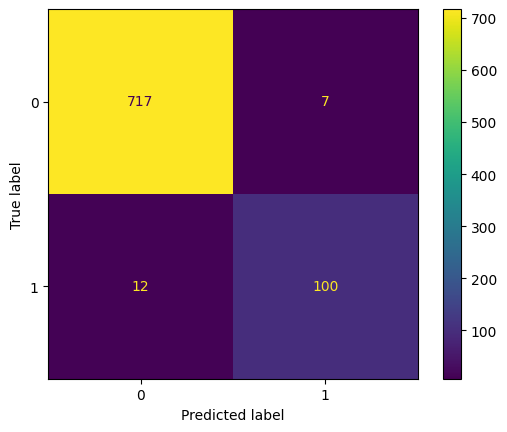

In [8]:
acc, pre, re, pr = model.evaluate(valid_loader)
model.saveResults("pytorch", "cnn", "valid", acc, pre, re, pr)

Accuracy: 0.9880382775119617
Precision: 0.9473684210526315
Recall: 0.9642857142857143
PR_AUC: 0.9582194121667805


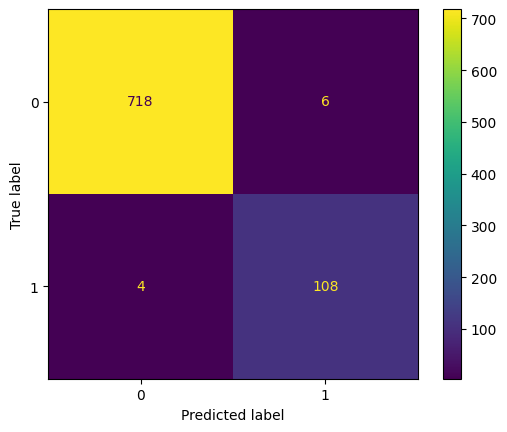

In [9]:
acc, pre, re, pr = model.evaluate(test_loader)
model.saveResults("pytorch", "cnn", "test", acc, pre, re, pr)